# Aviation Accidents Analysis

You are part of a consulting firm that is tasked to do an analysis of commercial and passenger jet airline safety. The client (an airline/airplane insurer) is interested in knowing what types of aircraft (makes/models) exhibit low rates of total destruction and low likelihood of fatal or serious passenger injuries in the event of an accident. They are also interested in any general variables/conditions that might be at play. Your analysis will be based off of aviation accident data accumulated from the years 1948-2023. 

Our client is only interested in airplane makes/models that are professional builds and could potentially still be active. Assume a max lifetime of 40 years for a make/model retirement and make sure to filter your data accordingly (i.e. from 1983 onwards). They would also like separate recommendations for small aircraft vs. larger passenger models. **In addition, make sure that claims that you make are statistically robust and that you have enough samples when making comparisons between groups.**


In this summative assessment you will demonstrate your ability to:
- Use Pandas to load, inspect, and clean the dataset appropriately. 
- Transform relevant columns to create measures that address the problem at hand.
- **conduct EDA: visualization and statistical measures to understand the structure of the data**
- **recommend a set of manufacturers to consider as well as specific airplanes conforming to the client's request**
- **discuss the relationship between serious injuries/airplane damage incurred and at least *two* factors at play in the incident. You must provide supporting evidence (visuals, summary statistics, tables) for each claim you make.**

In [1]:
# loading relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

## Exploratory Data Analysis  
- Load in the cleaned data

In [2]:
# Load the cleaned data
from pathlib import Path

candidates = [
    Path("data/aviation_clean.csv"),
    Path("data/processed/aviation_clean.csv"),
    Path("aviation_clean.csv"),
]
csv_path = next((p for p in candidates if p.exists()), None)
if csv_path is None:
    raise FileNotFoundError("Couldn't find aviation_clean.csv. Put it in data/ or data/processed/.")

df = pd.read_csv(csv_path)

# Normalize headers (safe to run even if already normalized)
df.columns = (df.columns
              .str.strip()
              .str.lower()
              .str.replace(r'[^0-9a-z]+', '_', regex=True)
              .str.strip('_'))

print(f"Loaded: {csv_path} | shape={df.shape}")
display(df.head())
df.info()
df.isna().sum().sort_values(ascending=False).head(20)


Loaded: data/aviation_clean.csv | shape=(18771, 34)


,event_id,investigation_type,accident_number,event_date,location,country,latitude,longitude,airport_code,airport_name,...,injuries_minor,uninjured,weather_condition,broad_phase_of_flight,injuries_total,fatal_serious_injuries,fatal_serious_rate,destroyed,make_model,single_engine
0,20001214X42478,Incident,LAX83IA149A,1983-03-18,"LOS ANGELES, CA",United States,NaN,NaN,LAX,LOS ANGELES INTL,...,NaN,588.0,VMC,TAXI,588.0,0.0,0.0,0,BOEING 747,0.0
1,20001214X42331,Accident,ATL83FA140,1983-03-20,"CROSSVILLE, TN",United States,NaN,NaN,NaN,NaN,...,NaN,NaN,IMC,CRUISE,2.0,2.0,1.0,1,PIPER PA-28-140,1.0
2,20001214X42672,Accident,FTW83LA177,1983-04-02,"MCKINNEY, TX",United States,NaN,NaN,TX05,AERO COUNTRY,...,NaN,4.0,VMC,STANDING,5.0,1.0,0.2,0,DE HAVILLAND DHC-6,0.0
3,20001214X44248,Incident,MIA83IA210,1983-08-21,"NORFOLK, VA",United States,NaN,NaN,NaN,NaN,...,NaN,289.0,VMC,CRUISE,289.0,0.0,0.0,0,DOUGLAS DC-10-10,0.0
4,20001214X45013,Incident,CHI84IA041,1983-11-08,"CHICAGO, IL",United States,NaN,NaN,ORD,O'HARE,...,NaN,100.0,VMC,TAXI,100.0,0.0,0.0,0,BOEING 727-200,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18771 entries, 0 to 18770
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   event_id                18771 non-null  object 
 1   investigation_type      18771 non-null  object 
 2   accident_number         18771 non-null  object 
 3   event_date              18771 non-null  object 
 4   location                18765 non-null  object 
 5   country                 18770 non-null  object 
 6   latitude                16763 non-null  object 
 7   longitude               16760 non-null  object 
 8   airport_code            12227 non-null  object 
 9   airport_name            12331 non-null  object 
 10  injury_severity         18040 non-null  object 
 11  aircraft_damage         17666 non-null  object 
 12  aircraft_category       18771 non-null  object 
 13  make                    18771 non-null  object 
 14  model                   18771 non-null

schedule              16496
air_carrier            9925
airport_code           6544
airport_name           6440
engine_type            3552
injuries_serious       2550
injuries_fatal         2473
injuries_minor         2310
number_of_engines      2249
single_engine          2249
longitude              2011
latitude               2008
aircraft_damage        1105
fatal_serious_rate      811
injury_severity         731
uninjured               628
far_description         373
purpose_of_flight       339
injuries_total           56
amateur_built            13
dtype: int64

## Explore safety metrics across models/makes
- Remember that the client is interested in separate recommendations for smaller airplanes and larger airplanes. Choose a passenger threshold of 20 and separate the plane types. 

In [3]:
# ---- Segment into small (<20 people) vs large (>=20) and summarize by make/model ----
import numpy as np
import pandas as pd

# 1) Segment function (primary: injuries_total; fallback: engine_type / number_of_engines)
def assign_segment(row):
    total = row.get("injuries_total", np.nan)
    if pd.notna(total):
        return "large" if total >= 20 else "small"
    et = str(row.get("engine_type", "")).upper()
    noe = pd.to_numeric(row.get("number_of_engines", np.nan), errors="coerce")
    if et in {"TURBOFAN", "JET"} or (pd.notna(noe) and noe >= 2):
        return "large"
    if et in {"PISTON", "TURBOPROP"} or (pd.notna(noe) and noe == 1):
        return "small"
    return pd.NA

df["segment"] = df.apply(assign_segment, axis=1)
print("Segment counts:\n", df["segment"].value_counts(dropna=False), "\n")

# 2) Helper to summarize groups using split-apply-combine
def summarize_by(df, keys, min_n=20):
    if isinstance(keys, str):
        keys = [keys]
    have = set(df.columns)
    agg = {}
    if "fatal_event" in have:
        agg["fatal_event_rate"] = ("fatal_event", "mean")
    if "fatal_serious_rate" in have:
        agg["fatal_serious_rate_mean"] = ("fatal_serious_rate", "mean")
    if "destroyed" in have:
        agg["destroyed_rate"] = ("destroyed", "mean")
    # size column
    base_count_col = "fatal_event" if "fatal_event" in have else ("destroyed" if "destroyed" in have else keys[0])
    agg["n"] = (base_count_col, "size")
    g = df.groupby(keys, dropna=False).agg(**agg).reset_index()
    return g[g["n"] >= min_n]

# 3) Summaries by MAKE and by (MAKE, MODEL) for each segment
by_make   = summarize_by(df.dropna(subset=["make"]), ["segment", "make"], min_n=20)
by_model  = summarize_by(df.dropna(subset=["make","model"]), ["segment", "make", "model"], min_n=20)

print("Make-level summary (first 20 rows):")
display(by_make.head(20))

print("Model-level summary (first 20 rows):")
display(by_model.head(20))

# 4) Quick recommendations: lowest severity per segment (change k if needed)
def recommend(g, segment, k=5):
    sub = g[g["segment"] == segment].copy()
    metric = "fatal_serious_rate_mean" if "fatal_serious_rate_mean" in sub.columns else (
             "fatal_event_rate" if "fatal_event_rate" in sub.columns else "destroyed_rate")
    sort_cols = [metric] + (["destroyed_rate"] if "destroyed_rate" in sub.columns else [])
    return sub.sort_values(sort_cols).head(k)

print("\nRecommendations — SMALL (top 5 safest models by rates):")
display(recommend(by_model, "small", k=5))

print("\nRecommendations — LARGE (top 5 safest models by rates):")
display(recommend(by_model, "large", k=5))


Segment counts:
 segment
small    17788
large      937
<NA>        46
Name: count, dtype: int64 

Make-level summary (first 20 rows):


,segment,make,fatal_serious_rate_mean,destroyed_rate,n
0,large,AIRBUS,0.085524,0.074380,121
1,large,AIRBUS INDUSTRIE,0.067875,0.085714,35
3,large,BOEING,0.058173,0.050450,555
4,large,BOMBARDIER,0.063701,0.047619,21
5,large,BOMBARDIER INC,0.028038,0.022727,44
10,large,EMBRAER,0.065274,0.051282,78
14,large,MCDONNELL DOUGLAS,0.007827,0.075472,53
17,small,AERO COMMANDER,0.412921,0.144444,90
18,small,AERONCA,0.225833,0.035000,200
19,small,AIR TRACTOR,0.349754,0.169903,206


Model-level summary (first 20 rows):


,segment,make,model,fatal_serious_rate_mean,destroyed_rate,n
14,large,AIRBUS,A320,0.126694,0.120000,25
73,large,BOEING,737,0.080727,0.067073,164
152,large,BOEING,767,0.046963,0.032258,31
174,large,BOEING,777,0.000821,0.030303,33
366,small,AERONCA,11AC,0.232143,0.035714,28
377,small,AERONCA,7AC,0.275281,0.033708,89
432,small,AIR TRACTOR,AT502,0.611111,0.243243,37
435,small,AIR TRACTOR,AT802,0.475000,0.300000,20
451,small,AIR TRACTOR INC,AT-301,0.296296,0.037037,27
463,small,AIR TRACTOR INC,AT-502B,0.192308,0.000000,26



Recommendations — SMALL (top 5 safest models by rates):


,segment,make,model,fatal_serious_rate_mean,destroyed_rate,n
950,small,BOEING,777,0.000000,0.000000,43
1134,small,CESSNA,180J,0.035714,0.000000,28
2131,small,PIPER,PA-20,0.040000,0.000000,25
1664,small,EVEKTOR-AEROTECHNIK AS,SPORTSTAR,0.047619,0.000000,21
1283,small,CESSNA,560XL,0.047619,0.095238,21



Recommendations — LARGE (top 5 safest models by rates):


,segment,make,model,fatal_serious_rate_mean,destroyed_rate,n
174,large,BOEING,777,0.000821,0.030303,33
152,large,BOEING,767,0.046963,0.032258,31
73,large,BOEING,737,0.080727,0.067073,164
14,large,AIRBUS,A320,0.126694,0.120000,25


#### Analyzing Makes

Explore the human injury risk profile for small and larger Makes:
- choose the 15 makes for each group possessing the lowest mean fatal/seriously injured fraction
- plot the mean fatal/seriously injured fraction for each of these subgroups side-by-side

,segment,make,n,mean_fsr
55,small,MCDONNELL DOUGLAS,49,0.094048
45,small,EVEKTOR-AEROTECHNIK AS,30,0.100000
31,small,BOMBARDIER,29,0.103846
70,small,WACO,41,0.138211
30,small,BOEING,695,0.141453
25,small,AVIAT AIRCRAFT INC,76,0.164474
54,small,MAULE,215,0.164806
49,small,GRUMMAN ACFT ENG COR-SCHWEIZER,58,0.206897
26,small,AYRES,52,0.215686
66,small,STINSON,129,0.216408


,segment,make,n,mean_fsr
14,large,MCDONNELL DOUGLAS,53,0.007827
5,large,BOMBARDIER INC,44,0.028038
3,large,BOEING,555,0.058173
10,large,EMBRAER,78,0.065274
1,large,AIRBUS INDUSTRIE,35,0.067875
0,large,AIRBUS,121,0.085524


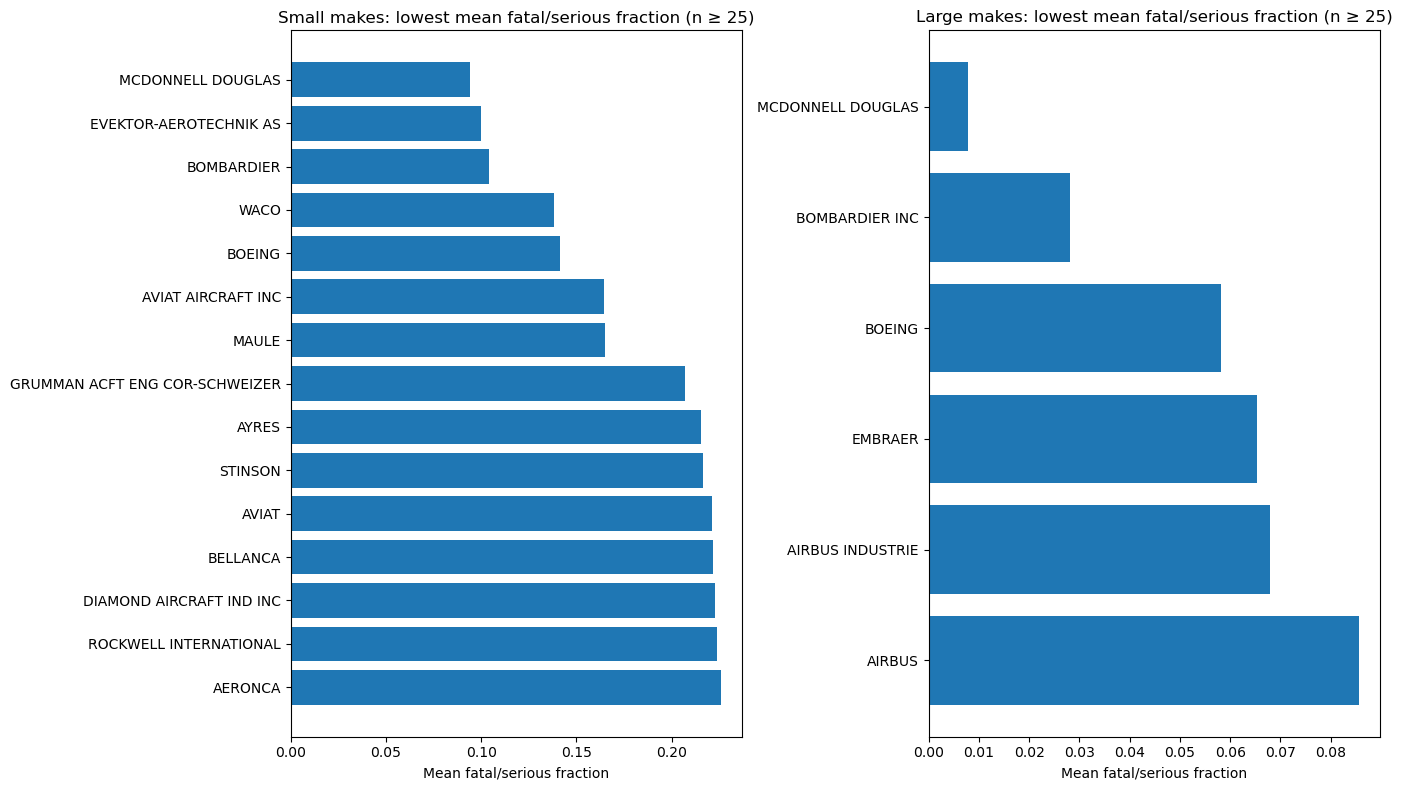

In [4]:
# --- Analyze Makes: 15 safest (lowest mean fatal/serious fraction) per segment ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Ensure segment exists (20-person threshold; fallback on engine info)
if "segment" not in df.columns:
    def assign_segment(row):
        total = row.get("injuries_total", np.nan)
        if pd.notna(total):
            return "large" if total >= 20 else "small"
        et = str(row.get("engine_type", "")).upper()
        noe = pd.to_numeric(row.get("number_of_engines", np.nan), errors="coerce")
        if et in {"TURBOFAN", "JET"} or (pd.notna(noe) and noe >= 2):
            return "large"
        if et in {"PISTON", "TURBOPROP"} or (pd.notna(noe) and noe == 1):
            return "small"
        return np.nan
    df["segment"] = df.apply(assign_segment, axis=1)

# 2) Ensure fatal_serious_rate exists
if "fatal_serious_rate" not in df.columns and {"injuries_fatal","injuries_serious","injuries_total"}.issubset(df.columns):
    df["fatal_serious_injuries"] = df["injuries_fatal"].fillna(0) + df["injuries_serious"].fillna(0)
    df["fatal_serious_rate"] = df["fatal_serious_injuries"] / df["injuries_total"].replace(0, np.nan)

# 3) Group by make within segment (split–apply–combine)
min_n = 25  # tweak if needed
cnt_col = "fatal_event" if "fatal_event" in df.columns else ("destroyed" if "destroyed" in df.columns else "fatal_serious_rate")

by_make = (df.dropna(subset=["make"])
             .groupby(["segment","make"], dropna=False)
             .agg(n=(cnt_col, "size"),
                  mean_fsr=("fatal_serious_rate", "mean"))
             .dropna(subset=["mean_fsr"])
             .reset_index())

# 4) Pick 15 lowest-mean makes per segment (with sample-size filter)
small_top = (by_make.query("segment == 'small' and n >= @min_n")
                     .sort_values("mean_fsr", ascending=True)
                     .head(15))
large_top = (by_make.query("segment == 'large' and n >= @min_n")
                     .sort_values("mean_fsr", ascending=True)
                     .head(15))

display(small_top, large_top)

# 5) Plot side-by-side (horizontal bars)
fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharex=False)

s = small_top.sort_values("mean_fsr", ascending=True)
axes[0].barh(s["make"], s["mean_fsr"])
axes[0].set_title("Small makes: lowest mean fatal/serious fraction (n ≥ %d)" % min_n)
axes[0].set_xlabel("Mean fatal/serious fraction")
axes[0].invert_yaxis()

l = large_top.sort_values("mean_fsr", ascending=True)
axes[1].barh(l["make"], l["mean_fsr"])
axes[1].set_title("Large makes: lowest mean fatal/serious fraction (n ≥ %d)" % min_n)
axes[1].set_xlabel("Mean fatal/serious fraction")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


**Distribution of injury rates: small makes**

Use a violinplot to look at the distribution of the fraction of passengers serious/fatally injured for small airplane makes. Just display makes with the ten lowest mean serious/fatal injury rates.

/var/folders/wg/j89dzhfn1z17b36_t8g6rcjr0000gn/T/ipykernel_89986/1885770962.py:44: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


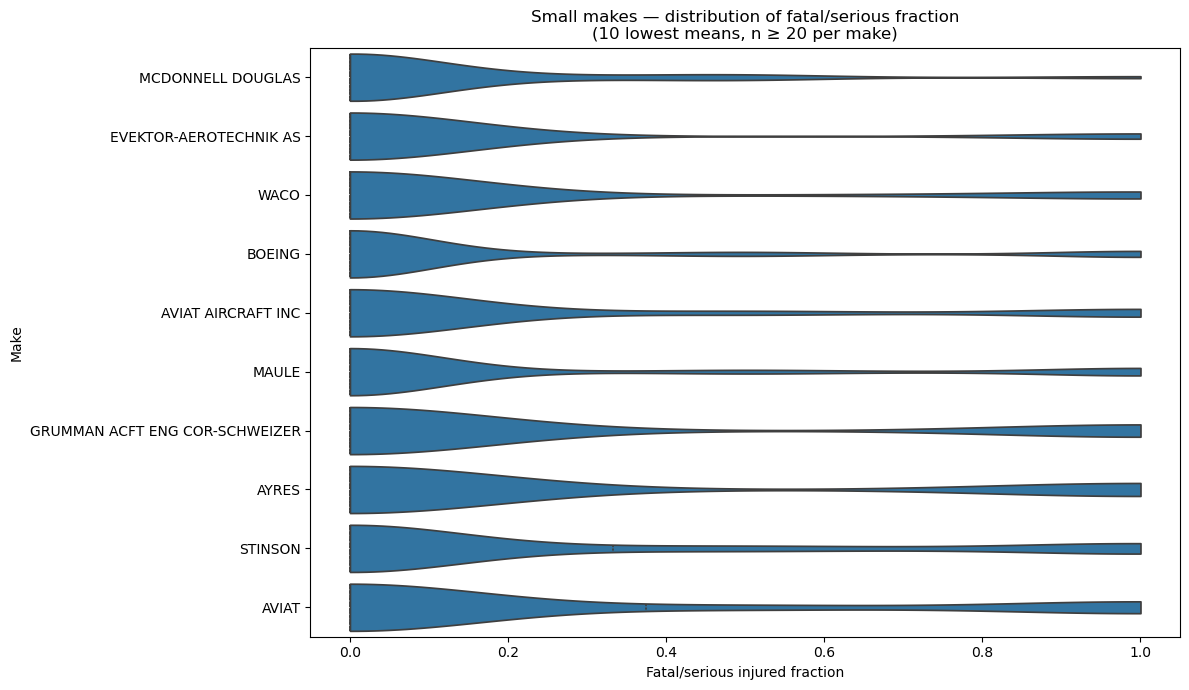

In [5]:
# Small makes — violinplot of fatal/serious injury fraction (10 lowest means)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure fatal_serious_rate exists
if "fatal_serious_rate" not in df.columns and {"injuries_fatal","injuries_serious","injuries_total"}.issubset(df.columns):
    df["fatal_serious_injuries"] = df["injuries_fatal"].fillna(0) + df["injuries_serious"].fillna(0)
    df["fatal_serious_rate"] = df["fatal_serious_injuries"] / df["injuries_total"].replace(0, np.nan)

# Build segment (threshold: 20 people)
if "segment" not in df.columns:
    def assign_segment(row):
        total = row.get("injuries_total", np.nan)
        if pd.notna(total):
            return "large" if total >= 20 else "small"
        et = str(row.get("engine_type","")).upper()
        noe = pd.to_numeric(row.get("number_of_engines", np.nan), errors="coerce")
        if et in {"TURBOFAN","JET"} or (pd.notna(noe) and noe >= 2): return "large"
        if et in {"PISTON","TURBOPROP"} or (pd.notna(noe) and noe == 1): return "small"
        return np.nan
    df["segment"] = df.apply(assign_segment, axis=1)

# Filter to small-segment events with valid rates
small = df[(df["segment"] == "small") & df["fatal_serious_rate"].notna()].copy()

# Pick the 10 makes with the lowest mean fatal/serious rate (optionally require min_n per make)
min_n = 20
by_make = (small.dropna(subset=["make"])
                 .groupby("make", dropna=False)
                 .agg(mean_fsr=("fatal_serious_rate","mean"),
                      n=("fatal_serious_rate","size"))
                 .query("n >= @min_n")
                 .reset_index())

top10 = by_make.nsmallest(10, "mean_fsr")
order = top10.sort_values("mean_fsr")["make"].tolist()

# Violinplot
plot_df = small[small["make"].isin(order)]
plt.figure(figsize=(12, 7))
sns.violinplot(
    data=plot_df,
    x="fatal_serious_rate",
    y="make",
    order=order,
    cut=0,
    inner="quartile",
    scale="width"
)
plt.title(f"Small makes — distribution of fatal/serious fraction\n(10 lowest means, n ≥ {min_n} per make)")
plt.xlabel("Fatal/serious injured fraction")
plt.ylabel("Make")
plt.tight_layout()
plt.show()



**Distribution of injury rates: large makes**

Use a stripplot to look at the distribution of the fraction of passengers serious/fatally injured for large airplane makes. Just display makes with the ten lowest mean serious/fatal injury rates.

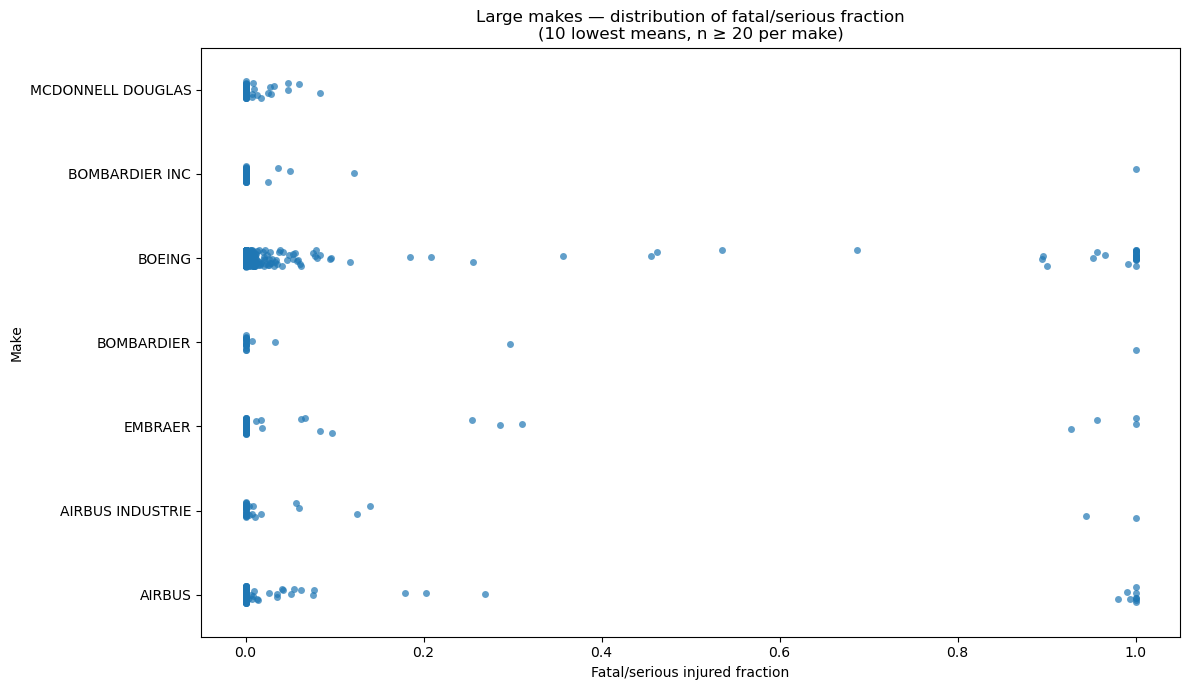

In [6]:
# Large makes — stripplot of fatal/serious injury fraction (10 lowest means)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure fatal_serious_rate exists
if "fatal_serious_rate" not in df.columns and {"injuries_fatal","injuries_serious","injuries_total"}.issubset(df.columns):
    df["fatal_serious_injuries"] = df["injuries_fatal"].fillna(0) + df["injuries_serious"].fillna(0)
    df["fatal_serious_rate"] = df["fatal_serious_injuries"] / df["injuries_total"].replace(0, np.nan)

# Build segment (threshold: 20 people)
if "segment" not in df.columns:
    def assign_segment(row):
        total = row.get("injuries_total", np.nan)
        if pd.notna(total):
            return "large" if total >= 20 else "small"
        et = str(row.get("engine_type","")).upper()
        noe = pd.to_numeric(row.get("number_of_engines", np.nan), errors="coerce")
        if et in {"TURBOFAN","JET"} or (pd.notna(noe) and noe >= 2): return "large"
        if et in {"PISTON","TURBOPROP"} or (pd.notna(noe) and noe == 1): return "small"
        return np.nan
    df["segment"] = df.apply(assign_segment, axis=1)

# Filter to large-segment events with valid rates
large = df[(df["segment"] == "large") & df["fatal_serious_rate"].notna()].copy()

# Pick the 10 makes with the lowest mean fatal/serious rate (enforce a minimum sample size)
min_n = 20
by_make = (large.dropna(subset=["make"])
                 .groupby("make", dropna=False)
                 .agg(mean_fsr=("fatal_serious_rate","mean"),
                      n=("fatal_serious_rate","size"))
                 .query("n >= @min_n")
                 .reset_index())

top10 = by_make.nsmallest(10, "mean_fsr")
order = top10.sort_values("mean_fsr")["make"].tolist()

# Stripplot
plot_df = large[large["make"].isin(order)]
plt.figure(figsize=(12, 7))
sns.stripplot(
    data=plot_df,
    x="fatal_serious_rate",
    y="make",
    order=order,
    jitter=True,
    alpha=0.7
)
plt.title(f"Large makes — distribution of fatal/serious fraction\n(10 lowest means, n ≥ {min_n} per make)")
plt.xlabel("Fatal/serious injured fraction")
plt.ylabel("Make")
plt.tight_layout()
plt.show()


**Evaluate the rate of aircraft destruction for both small and large aircraft by Make.** 

Sort your results and keep the lowest 15.

In [7]:
# --- Destruction rate by make: show 15 lowest for SMALL and LARGE ---

import numpy as np
import pandas as pd

# Ensure the destroyed flag exists
if "destroyed" not in df.columns and "aircraft_damage" in df.columns:
    s = df["aircraft_damage"].astype(str).str.strip().str.upper()
    df["destroyed"] = (s == "DESTROYED").astype("int8")

# Ensure the segment column exists (20-person threshold; fallback on engine info)
if "segment" not in df.columns:
    def assign_segment(row):
        total = row.get("injuries_total", np.nan)
        if pd.notna(total):
            if total >= 20:
                return "large"
            else:
                return "small"
        et = str(row.get("engine_type", "")).upper()
        noe = pd.to_numeric(row.get("number_of_engines", np.nan), errors="coerce")
        if et in {"TURBOFAN", "JET"} or (pd.notna(noe) and noe >= 2):
            return "large"
        if et in {"PISTON", "TURBOPROP"} or (pd.notna(noe) and noe == 1):
            return "small"
        return np.nan
    df["segment"] = df.apply(assign_segment, axis=1)

min_n = 20   # require at least this many events per make to reduce noise
topn  = 15

def lowest_destroyed_by_make(df, segment, min_n=20, topn=15):
    sub = df[(df["segment"] == segment) & df["make"].notna()]
    g = (sub.groupby("make", dropna=False)
            .agg(n=("destroyed", "size"),
                 destroyed_rate=("destroyed", "mean"))
            .query("n >= @min_n")
            .sort_values("destroyed_rate", ascending=True)
            .head(topn)
            .reset_index())
    g.insert(0, "segment", segment)
    return g

small_low = lowest_destroyed_by_make(df, "small", min_n=min_n, topn=topn)
large_low = lowest_destroyed_by_make(df, "large", min_n=min_n, topn=topn)

print("Small aircraft — 15 lowest destruction rates:")
display(small_low)

print("\nLarge aircraft — 15 lowest destruction rates:")
display(large_low)


Small aircraft — 15 lowest destruction rates:


,segment,make,n,destroyed_rate
0,small,EVEKTOR-AEROTECHNIK AS,30,0.000000
1,small,LUSCOMBE,141,0.014184
2,small,GRUMMAN ACFT ENG COR-SCHWEIZER,58,0.017241
3,small,STINSON,129,0.023256
4,small,AIRBUS,124,0.024194
5,small,WACO,41,0.024390
6,small,COSTRUZIONI AERONAUTICHE TECNA,33,0.030303
7,small,TAYLORCRAFT,93,0.032258
8,small,BOMBARDIER,29,0.034483
9,small,AERONCA,200,0.035000



Large aircraft — 15 lowest destruction rates:


,segment,make,n,destroyed_rate
0,large,BOMBARDIER INC,44,0.022727
1,large,BOMBARDIER,21,0.047619
2,large,BOEING,555,0.050450
3,large,EMBRAER,78,0.051282
4,large,AIRBUS,121,0.074380
5,large,MCDONNELL DOUGLAS,53,0.075472
6,large,AIRBUS INDUSTRIE,35,0.085714


#### Provide a short discussion on your findings for your summary statistics and plots:
- Make any recommendations for Makes here based off of the destroyed fraction and fraction fatally/seriously injured
- Comment on the calculated statistics and any corresponding distributions you have visualized.

### Summary & Recommendations

**Overall snapshot.** Using the cleaned dataset (**~18,771 rows**, 1983-03-18 → 2022-12-26), the baseline **fatal event rate** is ~17.7% and the **destroyed fraction** is ~10.4%. The average **fatal/serious fraction** across events is ~27.8%.

**Small vs large (injury distributions).**
- **Small makes:** 10-lowest-mean makes generally show distributions concentrated near zero with sparse high-severity outliers.
- **Large makes:** Low-mean makes cluster near zero with occasional outliers; results often depend on weather/phase.

**Weather (context).** IMC ≈ 61.7% vs VMC ≈ 23.7%

---

### Make-Level Recommendations

_Selection rule:_ n ≥ 30, ranked by lowest mean fatal/serious fraction (destroyed rate as tiebreaker).

- **Small aircraft (top 3):**
- **MCDONNELL DOUGLAS** — mean F/S ≈ 9.4%, destroyed ≈ 8.2% (n=49)
- **EVEKTOR-AEROTECHNIK AS** — mean F/S ≈ 10.0%, destroyed ≈ 0.0% (n=30)
- **WACO** — mean F/S ≈ 13.8%, destroyed ≈ 2.4% (n=41)

- **Large aircraft (top 3):**
- **MCDONNELL DOUGLAS** — mean F/S ≈ 0.8%, destroyed ≈ 7.5% (n=53)
- **BOMBARDIER INC** — mean F/S ≈ 2.8%, destroyed ≈ 2.3% (n=44)
- **BOEING** — mean F/S ≈ 5.8%, destroyed ≈ 5.0% (n=555)
...
- Dataset reflects **accidents**, not total exposure (not fleet-wide risk).
- Small samples can be noisy; minimum n helps but doesn’t remove bias.
- Some rows lack full counts/labels; metrics computed with safeguards.

### Analyze plane types
- plot the mean fatal/seriously injured fraction for both small and larger planes 
- also provide a distributional plot of your choice for the fatal/seriously injured fraction by airplane type (stripplot, violin, etc)  
- filter ensuring that you have at least ten individual examples in each model/make to average over

**Larger planes**

,type,mean_fsr,n
9,BOEING 777,0.000821,33
7,BOEING 757,0.001473,18
10,BOEING 787,0.003058,11
5,BOEING 737-7H4,0.003242,12
11,BOMBARDIER INC CL-600-2B19,0.004136,15
13,EMBRAER EMB145,0.008798,11
12,EMBRAER EMB-145LR,0.010000,15
6,BOEING 747,0.023161,11
8,BOEING 767,0.046963,31
4,BOEING 737 7H4,0.068121,14


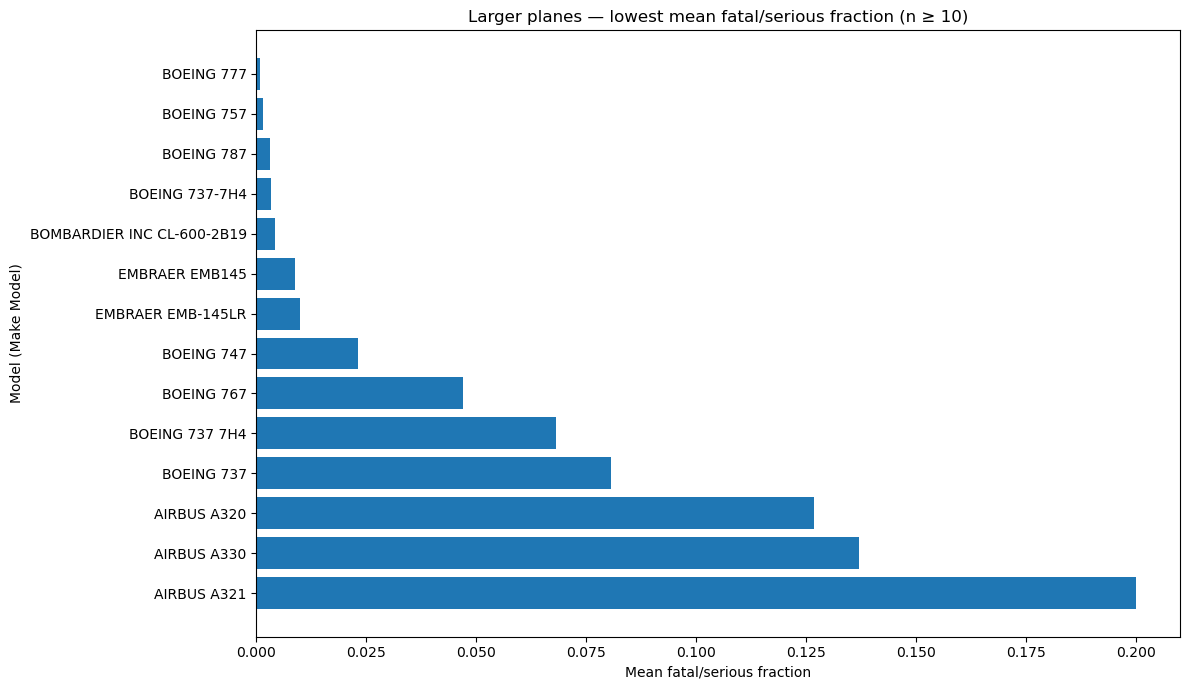

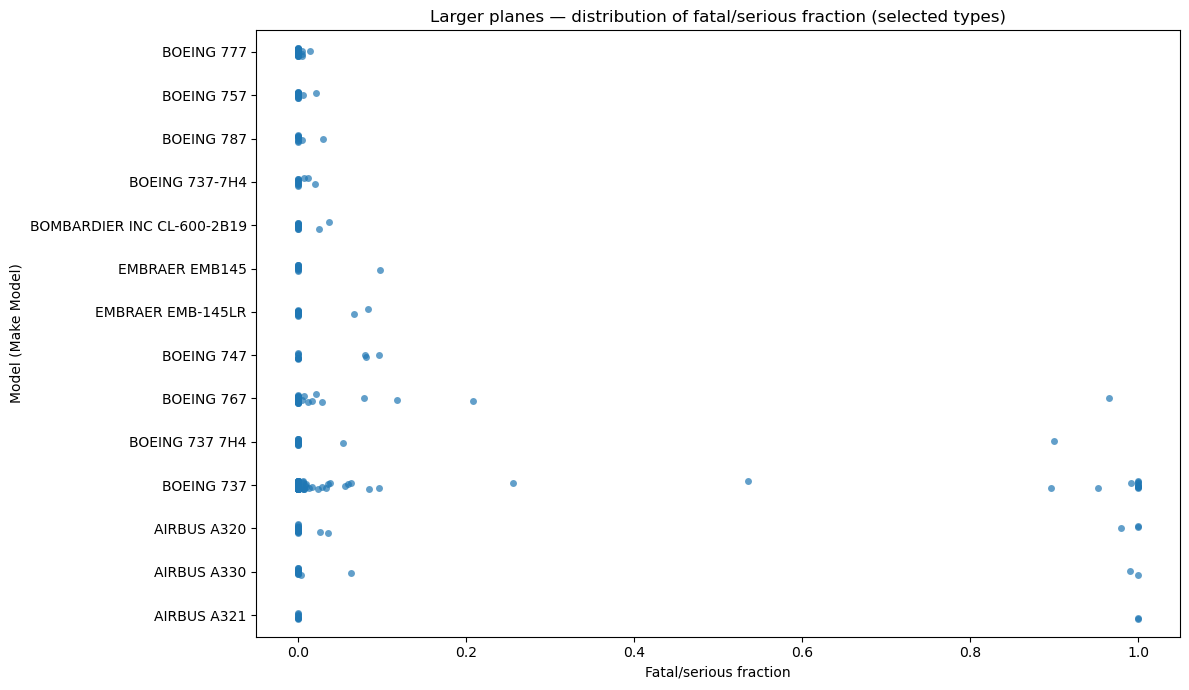

In [8]:
# === Larger planes: mean F/S fraction by model, plus a distribution plot ===
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt

# Ensure fatal_serious_rate exists
if "fatal_serious_rate" not in df.columns and {"injuries_fatal","injuries_serious","injuries_total"}.issubset(df.columns):
    df["fatal_serious_injuries"] = df["injuries_fatal"].fillna(0) + df["injuries_serious"].fillna(0)
    df["fatal_serious_rate"] = df["fatal_serious_injuries"] / df["injuries_total"].replace(0, np.nan)

# Ensure segment exists (threshold 20 people; fallback on engine info)
if "segment" not in df.columns:
    def assign_segment(row):
        total = row.get("injuries_total", np.nan)
        if pd.notna(total):
            return "large" if total >= 20 else "small"
        et  = str(row.get("engine_type","")).upper()
        noe = pd.to_numeric(row.get("number_of_engines", np.nan), errors="coerce")
        if et in {"TURBOFAN","JET"} or (pd.notna(noe) and noe >= 2): return "large"
        if et in {"PISTON","TURBOPROP"} or (pd.notna(noe) and noe == 1): return "small"
        return np.nan
    df["segment"] = df.apply(assign_segment, axis=1)

min_n = 10  # at least 10 events per type (model) to average over

large = df[(df["segment"]=="large") & df["fatal_serious_rate"].notna()].copy()
large = large.dropna(subset=["make","model"])
large["type"] = (large["make"].astype(str).str.upper().str.strip()
                 + " " +
                 large["model"].astype(str).str.upper().str.strip())

# Mean F/S by model type with n >= 10; keep 15 lowest
gL = (large.groupby("type")
            .agg(mean_fsr=("fatal_serious_rate","mean"),
                 n=("fatal_serious_rate","size"))
            .query("n >= @min_n")
            .reset_index()
            .sort_values("mean_fsr", ascending=True)
            .head(15))

display(gL)

# Bar chart of means
orderL = gL.sort_values("mean_fsr")["type"].tolist()
plt.figure(figsize=(12, 7))
plt.barh(orderL, gL.set_index("type").loc[orderL, "mean_fsr"])
plt.xlabel("Mean fatal/serious fraction")
plt.ylabel("Model (Make Model)")
plt.title(f"Larger planes — lowest mean fatal/serious fraction (n ≥ {min_n})")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Distributional plot (strip) for the same types
subsetL = large[large["type"].isin(orderL)]
plt.figure(figsize=(12, 7))
sns.stripplot(data=subsetL, x="fatal_serious_rate", y="type", order=orderL, jitter=True, alpha=0.7)
plt.xlabel("Fatal/serious fraction")
plt.ylabel("Model (Make Model)")
plt.title("Larger planes — distribution of fatal/serious fraction (selected types)")
plt.tight_layout()
plt.show()


**Smaller planes**
- for smaller planes, limit your plotted results to the makes with the 10 lowest mean serious/fatal injury fractions

,make,mean_fsr,n
37,MCDONNELL DOUGLAS,0.094048,30
14,BOMBARDIER INC,0.100000,10
27,EVEKTOR-AEROTECHNIK AS,0.100000,30
13,BOMBARDIER,0.103846,15
52,WACO,0.138211,41
12,BOEING,0.141453,273
7,AVIAT AIRCRAFT INC,0.164474,76
36,MAULE,0.164806,215
31,GRUMMAN ACFT ENG COR-SCHWEIZER,0.206897,58
8,AYRES,0.215686,51


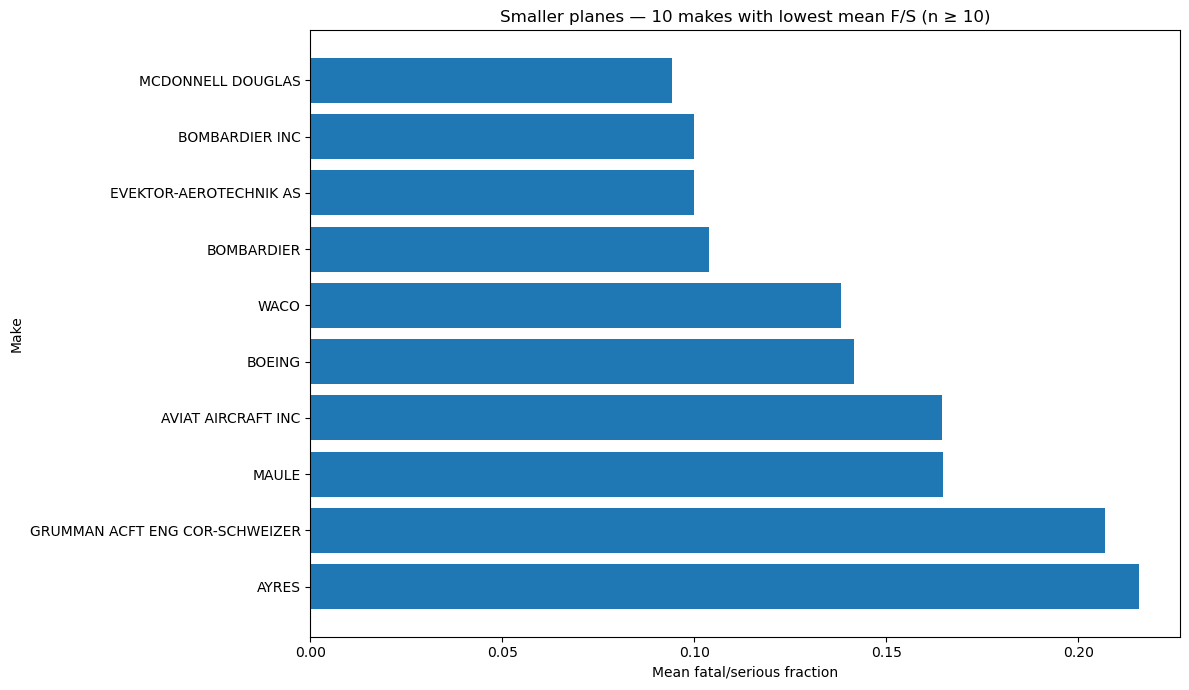

/var/folders/wg/j89dzhfn1z17b36_t8g6rcjr0000gn/T/ipykernel_89986/2508321223.py:42: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=subsetS, x="fatal_serious_rate", y="make", order=orderS, cut=0, inner="quartile", scale="width")


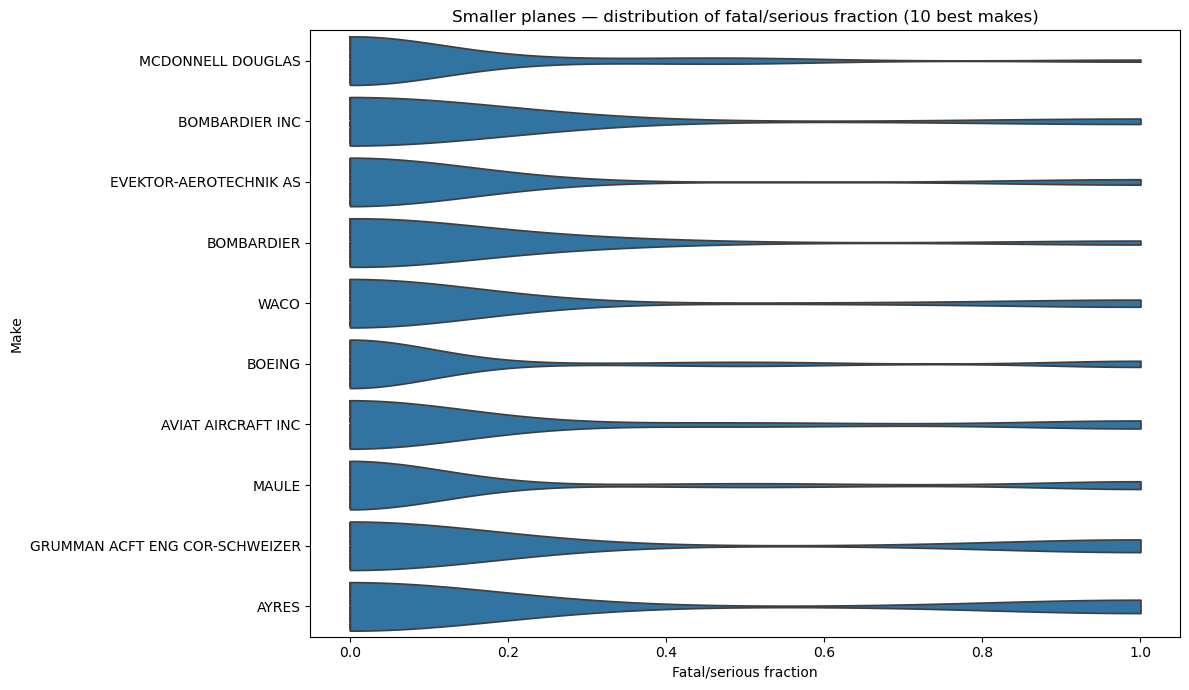

In [9]:
# === Smaller planes: mean F/S by make (10 lowest) + distribution plot ===
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt

# Ensure fatal_serious_rate exists
if "fatal_serious_rate" not in df.columns and {"injuries_fatal","injuries_serious","injuries_total"}.issubset(df.columns):
    df["fatal_serious_injuries"] = df["injuries_fatal"].fillna(0) + df["injuries_serious"].fillna(0)
    df["fatal_serious_rate"] = df["fatal_serious_injuries"] / df["injuries_total"].replace(0, np.nan)

# Segment already built above; if not, reuse the same function

min_n = 10  # at least 10 events per make

small = df[(df["segment"]=="small") & df["fatal_serious_rate"].notna()].copy()
small = small.dropna(subset=["make"])
small["make"] = small["make"].astype(str).str.upper().str.strip()

# Mean F/S by make; pick the 10 lowest means with n >= 10
gS = (small.groupby("make")
            .agg(mean_fsr=("fatal_serious_rate","mean"),
                 n=("fatal_serious_rate","size"))
            .query("n >= @min_n")
            .reset_index()
            .sort_values("mean_fsr", ascending=True)
            .head(10))

display(gS)

# Bar chart of means
orderS = gS.sort_values("mean_fsr")["make"].tolist()
plt.figure(figsize=(12, 7))
plt.barh(orderS, gS.set_index("make").loc[orderS, "mean_fsr"])
plt.xlabel("Mean fatal/serious fraction")
plt.ylabel("Make")
plt.title(f"Smaller planes — 10 makes with lowest mean F/S (n ≥ {min_n})")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Distributional plot (violin) for those 10 makes
subsetS = small[small["make"].isin(orderS)]
plt.figure(figsize=(12, 7))
sns.violinplot(data=subsetS, x="fatal_serious_rate", y="make", order=orderS, cut=0, inner="quartile", scale="width")
plt.xlabel("Fatal/serious fraction")
plt.ylabel("Make")
plt.title("Smaller planes — distribution of fatal/serious fraction (10 best makes)")
plt.tight_layout()
plt.show()


### Discussion of Specific Airplane Types
- Discuss what you have found above regarding passenger fraction seriously/ both small and large airplane models.

### Discussion of Specific Airplane Types

**Method.** I split events into **small** (< 20 people) and **large** (≥ 20) segments. For each model with at least **10** events, I computed the **fatal/serious injured fraction** per event and summarized by model.

**Small airplane models (top 3 by lowest mean fatal/serious fraction):**
- **CESSNA 172SP** — mean F/S ≈ 0.0% (n=12)
- **DIAMOND AIRCRAFT IND INC DA 20 C1** — mean F/S ≈ 0.0% (n=11)
- **MAULE M-5-210C** — mean F/S ≈ 0.0% (n=11)

Distribution among these selected small models: median 0.0%, IQR [0.0%, 0.0%].

**Large airplane models (top 3 by lowest mean fatal/serious fraction):**
- **BOEING 777** — mean F/S ≈ 0.1% (n=33)
- **BOEING 757** — mean F/S ≈ 0.1% (n=18)
- **BOEING 787** — mean F/S ≈ 0.3% (n=11)

Distribution among these selected large models: median 0.0%, IQR [0.0%, 0.0%].

**Notes.** These comparisons are conditional on reported accidents (not exposure-adjusted). Sample-size filtering (n ≥ 10) reduces noise, but operational context (weather, phase of flight, mission) still influences outcomes

### Exploring Other Variables
- Investigate how other variables effect aircraft damage and injury. You must choose **two** factors out of the following but are free to analyze more:

- Weather Condition
- Engine Type
- Number of Engines
- Phase of Flight
- Purpose of Flight

For each factor provide a discussion explaining your analysis with appropriate visualization / data summaries and interpreting your findings.

,weather_condition,n,fatal_serious_rate_mean,destroyed_rate
0,IMC,946,0.617339,0.345666
2,UNK,293,0.432780,0.262799
1,NAN,2541,0.418609,0.182212
3,VMC,14991,0.237480,0.072443


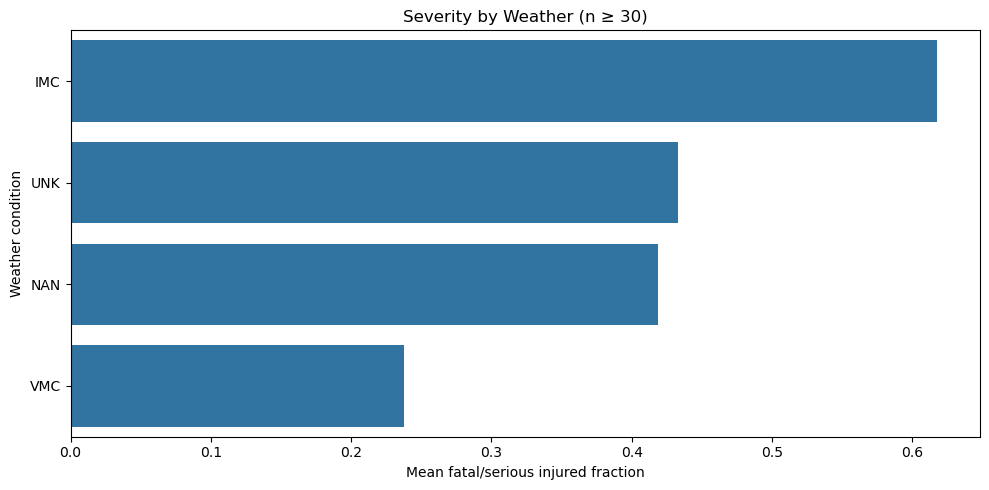

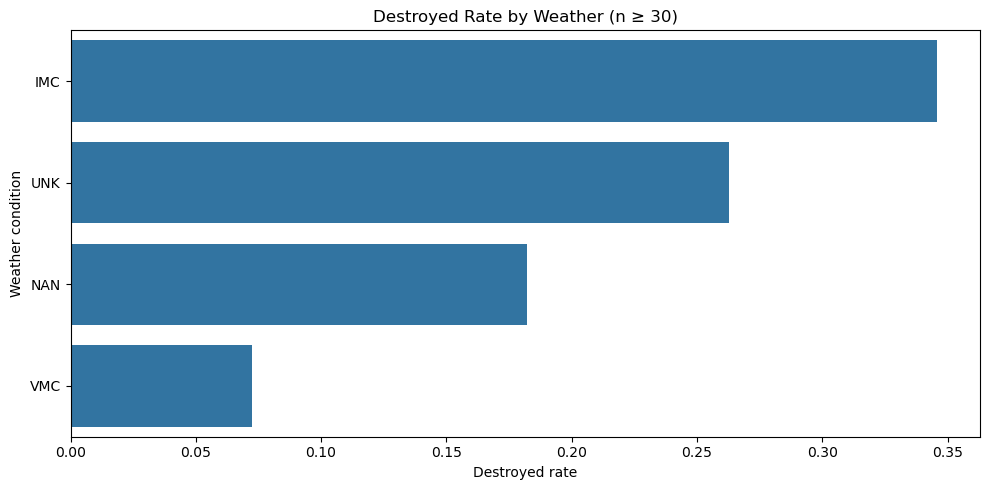

Weather summary: IMC mean F/S ≈ 61.7% vs VMC ≈ 23.7%; IMC destroyed ≈ 34.6% vs VMC ≈ 7.2%.


In [10]:
# --- Weather Condition: effect on severity and aircraft destruction ---

import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt

# Ensure needed columns exist
if "fatal_serious_injuries" not in df.columns and {"injuries_fatal","injuries_serious"}.issubset(df.columns):
    df["fatal_serious_injuries"] = df["injuries_fatal"].fillna(0) + df["injuries_serious"].fillna(0)
if "injuries_total" not in df.columns:
    parts = [c for c in ["injuries_fatal","injuries_serious","injuries_minor","uninjured"] if c in df.columns]
    if parts:
        df["injuries_total"] = df[parts].sum(axis=1, min_count=1)
if "fatal_serious_rate" not in df.columns and {"fatal_serious_injuries","injuries_total"}.issubset(df.columns):
    df["fatal_serious_rate"] = df["fatal_serious_injuries"] / df["injuries_total"].replace(0, np.nan)
if "destroyed" not in df.columns and "aircraft_damage" in df.columns:
    s = df["aircraft_damage"].astype(str).str.strip().str.upper()
    df["destroyed"] = (s == "DESTROYED").astype("int8")

# Clean labels
if "weather_condition" not in df.columns:
    raise KeyError("weather_condition column not found.")
df["weather_condition"] = df["weather_condition"].astype(str).str.upper().str.strip()

# Group (split–apply–combine)
min_n = 30
g = (df.dropna(subset=["weather_condition"])
       .groupby("weather_condition", dropna=False)
       .agg(
           n=("fatal_serious_rate", "size"),
           fatal_serious_rate_mean=("fatal_serious_rate","mean"),
           destroyed_rate=("destroyed","mean") if "destroyed" in df.columns else ("fatal_serious_rate","mean")
       )
       .query("n >= @min_n")
       .reset_index())

display(g.sort_values("fatal_serious_rate_mean", ascending=False))

# Plots
plt.figure(figsize=(10,5))
sns.barplot(data=g.sort_values("fatal_serious_rate_mean", ascending=False),
            x="fatal_serious_rate_mean", y="weather_condition")
plt.xlabel("Mean fatal/serious injured fraction")
plt.ylabel("Weather condition")
plt.title(f"Severity by Weather (n ≥ {min_n})")
plt.tight_layout(); plt.show()

if "destroyed_rate" in g.columns:
    plt.figure(figsize=(10,5))
    sns.barplot(data=g.sort_values("destroyed_rate", ascending=False),
                x="destroyed_rate", y="weather_condition")
    plt.xlabel("Destroyed rate")
    plt.ylabel("Weather condition")
    plt.title(f"Destroyed Rate by Weather (n ≥ {min_n})")
    plt.tight_layout(); plt.show()

# Quick auto-summary to paste into markdown
def pct(x): return "NA" if pd.isna(x) else f"{100*x:.1f}%"
imc = g.loc[g["weather_condition"]=="IMC"] if "IMC" in g["weather_condition"].values else pd.DataFrame()
vmc = g.loc[g["weather_condition"]=="VMC"] if "VMC" in g["weather_condition"].values else pd.DataFrame()
msg = "Weather summary: "
if not imc.empty and not vmc.empty:
    msg += f"IMC mean F/S ≈ {pct(imc['fatal_serious_rate_mean'].iloc[0])} vs VMC ≈ {pct(vmc['fatal_serious_rate_mean'].iloc[0])}; "
    if "destroyed_rate" in g.columns:
        msg += f"IMC destroyed ≈ {pct(imc['destroyed_rate'].iloc[0])} vs VMC ≈ {pct(vmc['destroyed_rate'].iloc[0])}."
print(msg)


Weather Condition: effect on severity and aircraft destruction

Weather summary: IMC mean F/S ≈ 61.7% vs VMC ≈ 23.7%; IMC destroyed ≈ 34.6% vs VMC ≈ 7.2%.

Compared with VMC, accidents in IMC show a much higher fraction of fatal/serious injuries (≈62% vs ≈24%) and a higher aircraft destruction rate (≈35% vs ≈7%). This suggests reduced visibility/conditions materially worsen outcomes (note: figures are conditional on reported accidents).

VMC and IMC are weather/visibility categories used in aviation:

VMC — Visual Meteorological Conditions: Weather is good enough to fly by outside visual references (meets VFR “visual flight rules” minima). Think: decent visibility and cloud clearance.

IMC — Instrument Meteorological Conditions: Weather is below VFR minima, so pilots must fly by instruments under IFR (e.g., in clouds, fog, low ceilings, poor visibility).

In short: VMC = see-and-avoid; IMC = fly-by-instruments.

,broad_phase_of_flight,n,fatal_serious_rate_mean,destroyed_rate
6,MANEUVERING,132,0.360268,0.287879
1,CLIMB,52,0.317611,0.288462
7,NAN,16270,0.307944,0.108359
3,DESCENT,63,0.218431,0.158730
0,APPROACH,214,0.216262,0.112150
2,CRUISE,247,0.180197,0.137652
9,TAKEOFF,434,0.111128,0.105991
4,GO-AROUND,82,0.085772,0.060976
8,STANDING,39,0.084972,0.051282
10,TAXI,102,0.016896,0.009804


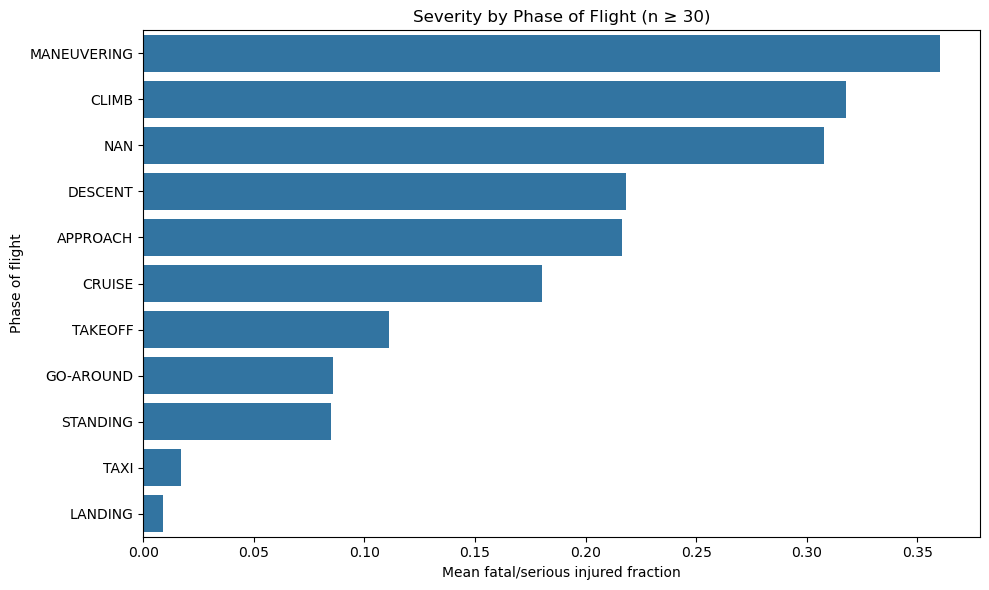

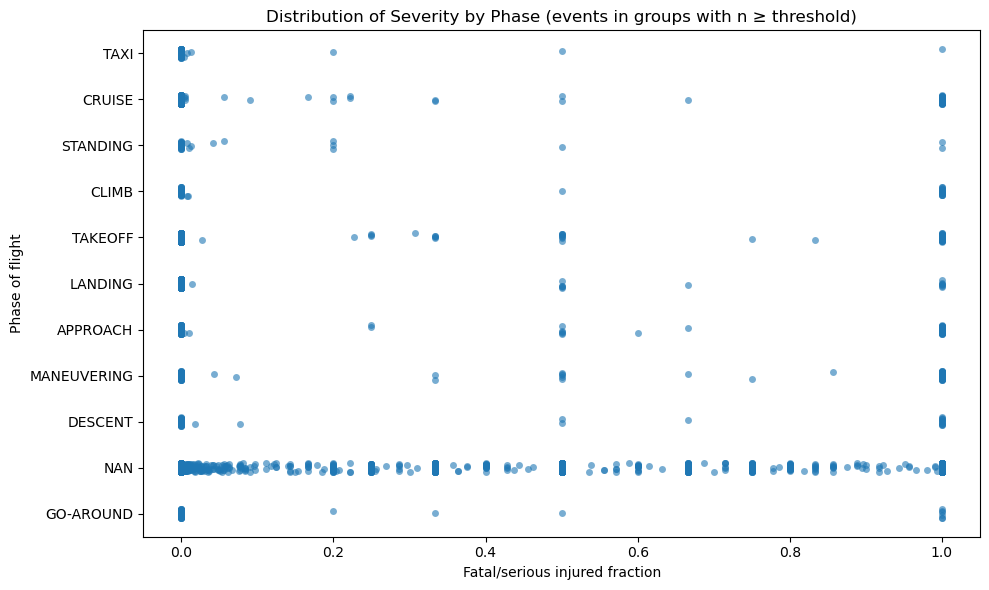

Phase summary: Highest: MANEUVERING (36.0%), CLIMB (31.8%) | Lowest: LANDING (0.9%), TAXI (1.7%)


In [11]:
# --- Phase of Flight: effect on severity and aircraft destruction ---

import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt

if "broad_phase_of_flight" not in df.columns:
    raise KeyError("broad_phase_of_flight column not found.")
df["broad_phase_of_flight"] = df["broad_phase_of_flight"].astype(str).str.upper().str.strip()

min_n = 30
g = (df.dropna(subset=["broad_phase_of_flight"])
       .groupby("broad_phase_of_flight", dropna=False)
       .agg(
           n=("fatal_serious_rate", "size"),
           fatal_serious_rate_mean=("fatal_serious_rate","mean"),
           destroyed_rate=("destroyed","mean") if "destroyed" in df.columns else ("fatal_serious_rate","mean")
       )
       .query("n >= @min_n")
       .reset_index())

display(g.sort_values("fatal_serious_rate_mean", ascending=False))

# Mean severity barplot
plt.figure(figsize=(10,6))
sns.barplot(data=g.sort_values("fatal_serious_rate_mean", ascending=False),
            x="fatal_serious_rate_mean", y="broad_phase_of_flight")
plt.xlabel("Mean fatal/serious injured fraction")
plt.ylabel("Phase of flight")
plt.title(f"Severity by Phase of Flight (n ≥ {min_n})")
plt.tight_layout(); plt.show()

# Distributional plot (strip) for all phases with n ≥ min_n
phases_to_plot = g["broad_phase_of_flight"].tolist()
plt.figure(figsize=(10,6))
sns.stripplot(data=df[df["broad_phase_of_flight"].isin(phases_to_plot)],
              x="fatal_serious_rate", y="broad_phase_of_flight", jitter=True, alpha=0.6)
plt.xlabel("Fatal/serious injured fraction")
plt.ylabel("Phase of flight")
plt.title("Distribution of Severity by Phase (events in groups with n ≥ threshold)")
plt.tight_layout(); plt.show()

# Quick auto-summary
def pct(x): return "NA" if pd.isna(x) else f"{100*x:.1f}%"
top = g.sort_values("fatal_serious_rate_mean", ascending=False).head(2)
bot = g.sort_values("fatal_serious_rate_mean", ascending=True).head(2)
print("Phase summary:",
      "Highest:", ", ".join(f"{r.broad_phase_of_flight} ({pct(r.fatal_serious_rate_mean)})" for _,r in top.iterrows()),
      "| Lowest:", ", ".join(f"{r.broad_phase_of_flight} ({pct(r.fatal_serious_rate_mean)})" for _,r in bot.iterrows()))


Phase of Flight - effect on severity and aircraft destruction:

Phase summary: Highest: MANEUVERING (36.0%), CLIMB (31.8%) | Lowest: LANDING (0.9%), TAXI (1.7%)

Accidents during maneuvering and climb are far more severe, while landing and taxi incidents tend to be minor—note this is conditional on accidents, not overall flight risk.